# Prioritisation of Episodes in Alert-Driven Attack Graphs

### Imports

In [28]:
import networkx as nx
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pygraphviz # Needs to be imported for some networkx functions
from enum import Enum
import math
import pandas as pd
import numpy as np

### Mappings

In [29]:
class MicroAttackStage(Enum):
    INIT = 0

    TARGET_IDEN = 0.25
    SURFING = 0.25
    SOCIAL_ENGINEERING = 0.25
    HOST_DISC = 0.25
    SERVICE_DISC = 0.25
    VULN_DISC = 0.25
    INFO_DISC = 0.25

    USER_PRIV_ESC = 0.5
    ROOT_PRIV_ESC = 0.5
    NETWORK_SNIFFING = 0.5
    BRUTE_FORCE_CREDS = 0.5
    ACCT_MANIP = 0.5
    TRUSTED_ORG_EXP = 0.5
    PUBLIC_APP_EXP = 0.5
    REMOTE_SERVICE_EXP = 0.5
    SPEARPHISHING = 0.5
    SERVICE_SPECIFIC = 0.5
    DEFENSE_EVASION = 0.5
    COMMAND_AND_CONTROL = 0.5
    LATERAL_MOVEMENT = 0.5
    ARBITRARY_CODE_EXE = 0.5
    PRIV_ESC = 0.5

    END_POINT_DOS = 1
    NETWORK_DOS = 1
    SERVICE_STOP = 1
    RESOURCE_HIJACKING = 1
    DATA_DESTRUCTION = 1
    CONTENT_WIPE = 1
    DATA_ENCRYPTION = 1
    DEFACEMENT = 1
    DATA_MANIPULATION = 1
    DATA_EXFILTRATION = 1
    DATA_DELIVERY = 1
    PHISHING = 1

    NON_MALICIOUS = 0

class MicroAttackStageConfidentiality(Enum):
    INIT = 0.1

    # Low Severity
    TARGET_IDEN = 0.1
    SURFING = 0.1
    SOCIAL_ENGINEERING = 0.25
    HOST_DISC = 0.25
    SERVICE_DISC = 0.25
    VULN_DISC = 0.25
    INFO_DISC = 0.25

    # Medium Severity
    USER_PRIV_ESC = 0.5
    ROOT_PRIV_ESC = 0.5
    NETWORK_SNIFFING = 0.5
    BRUTE_FORCE_CREDS = 0.5
    ACCT_MANIP = 0.5
    TRUSTED_ORG_EXP = 0.5
    PUBLIC_APP_EXP = 0.5
    REMOTE_SERVICE_EXP = 0.5
    SPEARPHISHING = 0.5
    SERVICE_SPECIFIC = 0.5
    DEFENSE_EVASION = 0.1
    COMMAND_AND_CONTROL = 0.5
    LATERAL_MOVEMENT = 0.5
    ARBITRARY_CODE_EXE = 0.5
    PRIV_ESC = 0.5

    # High Severity
    END_POINT_DOS = 0.1
    NETWORK_DOS = 0.1
    SERVICE_STOP = 0.1
    RESOURCE_HIJACKING = 0.1
    DATA_DESTRUCTION = 0.1
    CONTENT_WIPE = 0.1
    DATA_ENCRYPTION = 0.1
    DEFACEMENT = 1
    DATA_MANIPULATION = 0.1
    DATA_EXFILTRATION = 1
    DATA_DELIVERY = 0.1
    PHISHING = 1


class MicroAttackStageAvailability(Enum):
    INIT = 0.1

    # Low Severity
    TARGET_IDEN = 0.1
    SURFING = 0.1
    SOCIAL_ENGINEERING = 0.1
    HOST_DISC = 0.1
    SERVICE_DISC = 0.1
    VULN_DISC = 0.1
    INFO_DISC = 0.1

    # Medium Severity
    USER_PRIV_ESC = 0.5
    ROOT_PRIV_ESC = 0.5
    NETWORK_SNIFFING = 0.1
    BRUTE_FORCE_CREDS = 0.5
    ACCT_MANIP = 0.5
    TRUSTED_ORG_EXP = 0.1
    PUBLIC_APP_EXP = 0.5
    REMOTE_SERVICE_EXP = 0.1
    SPEARPHISHING = 0.1
    SERVICE_SPECIFIC = 0.5
    DEFENSE_EVASION = 0.1
    COMMAND_AND_CONTROL = 0.1
    LATERAL_MOVEMENT = 0.1
    ARBITRARY_CODE_EXE = 0.1
    PRIV_ESC = 0.1

    # High Severity
    END_POINT_DOS = 1
    NETWORK_DOS = 1
    SERVICE_STOP = 1
    RESOURCE_HIJACKING = 1
    DATA_DESTRUCTION = 1
    CONTENT_WIPE = 1
    DATA_ENCRYPTION = 1
    DEFACEMENT = 0.1
    DATA_MANIPULATION = 0.1
    DATA_EXFILTRATION = 0.1
    DATA_DELIVERY = 0.1
    PHISHING = 0.1

    NON_MALICIOUS = 0.1


class MicroAttackStageIntegrity(Enum):
    INIT = 0.1

    # Low Severity
    TARGET_IDEN = 0.1
    SURFING = 0.1
    SOCIAL_ENGINEERING = 0.1
    HOST_DISC = 0.1
    SERVICE_DISC = 0.1
    VULN_DISC = 0.25
    INFO_DISC = 0.1

    # Medium Severity
    USER_PRIV_ESC = 0.1
    ROOT_PRIV_ESC = 0.5
    NETWORK_SNIFFING = 0.1
    BRUTE_FORCE_CREDS = 0.1
    ACCT_MANIP = 0.5
    TRUSTED_ORG_EXP = 0.5
    PUBLIC_APP_EXP = 0.5
    REMOTE_SERVICE_EXP = 0.5
    SPEARPHISHING = 0.1
    SERVICE_SPECIFIC = 0.5
    DEFENSE_EVASION = 0.1
    COMMAND_AND_CONTROL = 0.5
    LATERAL_MOVEMENT = 0.5
    ARBITRARY_CODE_EXE = 0.5
    PRIV_ESC = 0.1

    # High Severity
    END_POINT_DOS = 0.1
    NETWORK_DOS = 0.1
    SERVICE_STOP = 0.1
    RESOURCE_HIJACKING = 0.1
    DATA_DESTRUCTION = 1
    CONTENT_WIPE = 1
    DATA_ENCRYPTION = 1
    DEFACEMENT = 1
    DATA_MANIPULATION = 1
    DATA_EXFILTRATION = 0.1
    DATA_DELIVERY = 1
    PHISHING = 0.1

    NON_MALICIOUS = 0.1


# AIF Mapping
verbose_micro = {'INIT': 'INITILIZE',
'TARGET_IDEN': 'TARGET IDENTIFICATION',
'SURFING': 'SURFING',
'SOCIAL_ENGINEERING': 'SOCIAL ENGINEERING',
'HOST_DISC': 'HOST DISCOVERY',
'SERVICE_DISC': 'SERVICE DISCOVERY',
'VULN_DISC': 'VULNERABILTY DISCOVERY',
'INFO_DISC': 'INFO DISCOVERY',
'USER_PRIV_ESC': 'USER PRIVILEGE ESCALATION',
'ROOT_PRIV_ESC': 'ROOT PRIVILEGE ESCALATION',
'NETWORK_SNIFFING': 'NETWORK SNIFFING',
'BRUTE_FORCE_CREDS': 'BRUTE FORCE CREDENTIALS',
'ACCT_MANIP': 'ACCOUNT MANIPULATION',
'TRUSTED_ORG_EXP': 'TRUSTED ORG. EXPLOIT',
'PUBLIC_APP_EXP': 'PUBLIC APP EXPLOIT',
'REMOTE_SERVICE_EXP': 'REMOTE SERVICE EXPLOIT',
'SPEARPHISHING': 'SPEAR PHISHING',
'SERVICE_SPECIFIC': 'SERVICE SPECIFIC',
'DEFENSE_EVASION': 'DEFENSE EVASION',
'COMMAND_AND_CONTROL': 'COMMAND AND CONTROL',
'LATERAL_MOVEMENT': 'LATERAL MOVEMENT',
'ARBITRARY_CODE_EXE': 'ARBITRARY CODE EXECUTION',
'PRIV_ESC': 'PRIVILEGE ESCALATION',
'END_POINT_DOS': 'END POINT DoS',
'NETWORK_DOS': 'NETWORK DoS',
'SERVICE_STOP': 'SERVICE STOP',
'RESOURCE_HIJACKING': 'RESOURCE HIJACKING',
'DATA_DESTRUCTION': 'DATA DESTRUCTION',
'CONTENT_WIPE': 'CONTENT WIPE',
'DATA_ENCRYPTION': 'DATA ENCRYPTION',
'DEFACEMENT': 'DEFACEMENT',
'DATA_MANIPULATION': 'DATA MANIPULATION',
'DATA_EXFILTRATION': 'DATA EXFILTRATION',
'DATA_DELIVERY': 'DATA DELIVERY',
'PHISHING': 'PHISHING',
'NON_MALICIOUS': 'NOT MALICIOUS'}

inverted_mapping = {v: k for k,v in verbose_micro.items()}

### Helper Methods

In [30]:
def print_sorted_dic(dic):
    """
    Print the given dictionary (key, score) sorted on the score.
    """
    arr = sorted(dic.items(), key= lambda x : -x[1])
    for i,el in enumerate(arr):
        print(i+1,el)

def get_urgency_ais(urgency, level="HIGH"):
    res = []

    if level == "HIGH":
        for aif,urgence in urgency.items():
            if urgence > .5:
                res.append(aif)
        return res
    elif level == "MED":
        for aif,urgence in urgency.items():
            if .5 >= urgence > .25:
                res.append(aif)
        return res

    elif level == "LOW":
        for aif,urgence in urgency.items():
            if urgence <= .25:
                res.append(aif)

        return res
    else:
        raise Exception("Wrong level provided")

def get_attack_stage(node):
    name = node.split("\n")[0].replace('"',"").replace("\r","")
    name = inverted_mapping[name]
    return name

In [31]:
debug = False

### Urgency Metrics
Baseline(AS) = Prevalence(AS) * Severity(AS)
Baseline(Node) = Baseline(AS)

PICA(node) = in_deg(node)/argmax(outdeg) * CIA
PICA(AS,x) = Avg(PICA(node)) for all nodes in highest x %

In [32]:
# Baseline Urgency Metric
def get_baseline(graph):
    """
    Calculate urgency for each attack stage in the graph.
    """
    aif_count = dict()

    # Count AS occurences
    for node in graph.nodes:
        # Ignore victim nodes
        if "Victim" in node:
            continue

        # Get attack stage and count
        name = get_attack_stage(node)
        aif_count[name] = aif_count.get(name, 0) + 1

    urgence = dict()

    # Calculate urgency for each AS
    for k,v in aif_count.items():
        severity = MicroAttackStage.__getitem__(k).value

        # Severity * Prevalence
        urgence[k] =  severity * v/len(graph.nodes)

    # Normalise to scale to [0,1]
    max_urgence = max(urgence.values())
    min_urgence = min(urgence.values())
    for k,v in urgence.items():
        urgence[k] = (v-min_urgence)/(max_urgence-min_urgence)

    return urgence

def get_baseline_nodes(graph):
    """
    Get baseline urgency for node-level
    """
    # Get AS urgencies
    urgency = get_baseline(final)

    node_urgency = dict()

    # For each node assign same urgency as its attack stage
    for node in graph.nodes:
        # Ignore victim nodes
        if "Victim" in node:
            continue

        attack_stage = get_attack_stage(node)
        node_urgency[node] = urgency[attack_stage]

    return node_urgency

In [6]:
# New Urgency Metric
def get_pica_nodes(graph, w1, w2, w3):
    urgence = dict()
    max_in = 0

    aif_count = dict()

    for node in graph.nodes:
        if "Victim" in node:
            continue

        # name = node.split("\n")[0].replace('"',"")
        name = get_attack_stage(node)
        aif_count[name] = aif_count.get(name, 0) + 1

    for node in graph.nodes:
        if "Victim" in node:
            continue

        max_in = max(max_in, len(graph.in_edges(node)))

        # name = node.split("\n")[0]
        non_verbose = get_attack_stage(node)

        confidentiality = MicroAttackStageConfidentiality.__getitem__(non_verbose).value
        availability = MicroAttackStageAvailability.__getitem__(non_verbose).value
        integrity = MicroAttackStageIntegrity.__getitem__(non_verbose).value
#         if "DISCOVERY" in node:
#             print((w1 * confidentiality + w2 * integrity + w3 * availability)/(w1+w2+w3))
        urgence[node] = (w1 * confidentiality + w2 * integrity + w3 * availability)/(w1+w2+w3)

    # Multiply by in-degree factor
    for node in graph.nodes:
        if "Victim" in node:
            continue
        if len(graph.in_edges(node)) == 0:
            urgence[node] = 1/max_in * urgence[node]
        else:
            urgence[node] = len(graph.in_edges(node))/max_in * urgence[node]


    # Normalise to [0,1]
    max_urgence = max(urgence.values())
    min_urgence = min(urgence.values())
    for node in graph.nodes:
        if "Victim" in node:
            continue

        urgence[node] = (urgence[node]-min_urgence)/(max_urgence-min_urgence)
#     print_sorted_dic(urgence)
    return urgence

def get_pica(graph, w1, w2, w3, percentage):
    return node_to_aif(get_pica_nodes(graph, w1, w2, w3), percentage)

def node_to_aif(urgence, percentage):
    aif_urgence = dict()

    # For AS, create a list of urgencies from the belonging nodes
    for node, urgency in urgence.items():
        name = get_attack_stage(node)

        if aif_urgence.get(name) is None:
            aif_urgence[name] = [urgency]
        else:
            aif_urgence.get(name).append(urgency)

    aif_avg_urg = dict()

    # For each AS, take the average of the highest X percentage
    for aif,nodes in aif_urgence.items():
        if nodes is None:
            continue
        sorted_dict = sorted(nodes, reverse=True)

        # Determine the number of items to include in the top X% based on the dictionary size
        top_25_percent_count = math.ceil(len(sorted_dict) * percentage)
        # if top_25_percent_count == 0:
        #     top_25_percent_count = 1
        #
        # Get the top 25% of values as a new dictionary
        top_25_percent_dict = sorted_dict[:top_25_percent_count]
        #
        aif_avg_urg[aif] = sum(top_25_percent_dict)/len(top_25_percent_dict)
        #
        # s = ["NETWORK_DOS", "DATA_EXFILTRATION"]
        # if aif in s:
        #     print(aif)
        #     print("percentage count",top_25_percent_count)
        #     print("dict length",len(sorted_dict))
        #     print("top percentage",top_25_percent_dict)
        #     print("final avg",sum(top_25_percent_dict)/len(top_25_percent_dict))

    max_v = max(aif_avg_urg.values())

    # Normalise to [0,1]
    # for k,v in aif_avg_urg.items():
    #     aif_avg_urg[k] = v/max_v
    #     # print("final normalised avg " + k,v/max_v)

    return aif_avg_urg

# Research Questions

### Load Graph

In [7]:
# final = nx.nx_pydot.read_dot(r"C:\Users\senne\Documents\University\TU Delft CSE\Y3\Q4\Research Project\SAGE\2017AGs\2017.txt-attack-graph-for-victim-10.0.0.1-DATADELIVERYhttp.dot")
# final = nx.nx_pydot.read_dot("./scripts/final.dot")
# final = nx.nx_pydot.read_dot("./2018Ags/2018.txt-attack-graph-for-victim-10.0.0.11-DATADELIVERYhttp.dot")
# final = nx.nx_pydot.read_dot("./2018AGs/2018.txt-attack-graph-for-victim-10.0.0.20-DATAEXFILTRATIONremotewarecl.dot")

# final = nx.nx_agraph.read_dot("./2018AGs/2018.txt-attack-graph-for-victim-10.0.0.24-DATADELIVERYwapwsp.dot")

## RQ1
### distribution of (low, medium, high) urgent attack stages

In [8]:
percentages = [0.01, 0.05,0.10, 0.15,0.25,0.33, 0.50, 0.75,1]

In [9]:
def execute_pica_percentages(graph, percentages):
    urgencies = []

    for percentage in percentages:
        # print(percentage)
        urgencies.append(get_pica(graph, 1, 1, 1, percentage))
        # print("--------------------------------------------")

    return urgencies

In [10]:
gr_2018 = nx.nx_agraph.read_dot("./2018AGs/combined/combined-2018.dot")
gr_2017 = nx.nx_agraph.read_dot("./2017AGs/combined/combined-2017.dot")
# final = nx.nx_agraph.read_dot("./2018AGs/2018.txt-attack-graph-for-victim-10.0.0.24-DATADELIVERYwapwsp.dot")
# final = nx.nx_agraph.read_dot(r"C:\Users\senne\Documents\University\TU Delft CSE\Y3\Q4\Research Project\SAGE\2018AGs\2018.txt-attack-graph-for-victim-10.0.0.24-DATAMANIPULATIONwapwsp.dot")
# final = nx.nx_agraph.read_dot(r"C:\Users\senne\Documents\University\TU Delft CSE\Y3\Q4\Research Project\SAGE\2018AGs\2018.txt-attack-graph-for-victim-10.0.0.24-NETWORKDOSssdp.dot")
linear = nx.nx_agraph.read_dot(r"C:\Users\senne\Documents\University\TU Delft CSE\Y3\Q4\Research Project\SAGE\2018AGs\2018.txt-attack-graph-for-victim-10.0.1.5-DATADELIVERYhttp.dot")

final = gr_2018


urgencies = execute_pica_percentages(final, percentages)

base_aif = get_baseline(final)
# print_sorted_dic(base_aif)

base_high = get_urgency_ais(base_aif, "HIGH")
base_med = get_urgency_ais(base_aif, "MED")
base_low = get_urgency_ais(base_aif, "LOW")

print(len(base_high), base_high)
print(len(base_med), base_med)
print(len(base_low), base_low)

8 ['DATA_DELIVERY', 'DATA_MANIPULATION', 'ARBITRARY_CODE_EXE', 'DATA_EXFILTRATION', 'REMOTE_SERVICE_EXP', 'ROOT_PRIV_ESC', 'ACCT_MANIP', 'RESOURCE_HIJACKING']
3 ['VULN_DISC', 'SERVICE_DISC', 'NETWORK_DOS']
9 ['INFO_DISC', 'HOST_DISC', 'SURFING', 'TRUSTED_ORG_EXP', 'COMMAND_AND_CONTROL', 'BRUTE_FORCE_CREDS', 'USER_PRIV_ESC', 'DATA_DESTRUCTION', 'PUBLIC_APP_EXP']


In [11]:
percentage_nr_hi = []
percentage_nr_me = []
percentage_nr_lo = []

for percentage, urgency in zip(percentages, urgencies):
    print(percentage)
    for val in ["HIGH", "MED", "LOW"]:
        print(len(get_urgency_ais(urgency, val)), get_urgency_ais(urgency, val))
    percentage_nr_hi.append(len(get_urgency_ais(urgency, "HIGH")))
    percentage_nr_me.append(len(get_urgency_ais(urgency, "MED")))
    percentage_nr_lo.append(len(get_urgency_ais(urgency, "LOW")))
    print()

0.01
10 ['DATA_DELIVERY', 'DATA_MANIPULATION', 'VULN_DISC', 'INFO_DISC', 'ARBITRARY_CODE_EXE', 'DATA_EXFILTRATION', 'NETWORK_DOS', 'ROOT_PRIV_ESC', 'ACCT_MANIP', 'RESOURCE_HIJACKING']
3 ['SERVICE_DISC', 'HOST_DISC', 'SURFING']
7 ['REMOTE_SERVICE_EXP', 'TRUSTED_ORG_EXP', 'COMMAND_AND_CONTROL', 'BRUTE_FORCE_CREDS', 'USER_PRIV_ESC', 'DATA_DESTRUCTION', 'PUBLIC_APP_EXP']

0.05
10 ['DATA_DELIVERY', 'DATA_MANIPULATION', 'VULN_DISC', 'INFO_DISC', 'ARBITRARY_CODE_EXE', 'DATA_EXFILTRATION', 'NETWORK_DOS', 'ROOT_PRIV_ESC', 'ACCT_MANIP', 'RESOURCE_HIJACKING']
3 ['SERVICE_DISC', 'HOST_DISC', 'SURFING']
7 ['REMOTE_SERVICE_EXP', 'TRUSTED_ORG_EXP', 'COMMAND_AND_CONTROL', 'BRUTE_FORCE_CREDS', 'USER_PRIV_ESC', 'DATA_DESTRUCTION', 'PUBLIC_APP_EXP']

0.1
6 ['DATA_DELIVERY', 'DATA_MANIPULATION', 'DATA_EXFILTRATION', 'NETWORK_DOS', 'ROOT_PRIV_ESC', 'ACCT_MANIP']
7 ['VULN_DISC', 'SERVICE_DISC', 'INFO_DISC', 'ARBITRARY_CODE_EXE', 'HOST_DISC', 'SURFING', 'RESOURCE_HIJACKING']
7 ['REMOTE_SERVICE_EXP', 'TRUSTED

In [12]:
for percentage, urgency in zip(percentages, urgencies):
    print(percentage)
    print_sorted_dic(urgency)

0.01
1 ('DATA_MANIPULATION', 1.0)
2 ('DATA_EXFILTRATION', 0.9466666666666667)
3 ('NETWORK_DOS', 0.9466666666666663)
4 ('ROOT_PRIV_ESC', 0.8533333333333332)
5 ('ACCT_MANIP', 0.8533333333333332)
6 ('DATA_DELIVERY', 0.7866666666666667)
7 ('INFO_DISC', 0.7466666666666665)
8 ('RESOURCE_HIJACKING', 0.7333333333333331)
9 ('ARBITRARY_CODE_EXE', 0.6222222222222221)
10 ('VULN_DISC', 0.5733333333333333)
11 ('SERVICE_DISC', 0.3866666666666666)
12 ('HOST_DISC', 0.30666666666666653)
13 ('SURFING', 0.29333333333333333)
14 ('COMMAND_AND_CONTROL', 0.2311111111111111)
15 ('REMOTE_SERVICE_EXP', 0.1333333333333333)
16 ('BRUTE_FORCE_CREDS', 0.08444444444444443)
17 ('DATA_DESTRUCTION', 0.07999999999999999)
18 ('PUBLIC_APP_EXP', 0.053333333333333316)
19 ('TRUSTED_ORG_EXP', 0.03555555555555555)
20 ('USER_PRIV_ESC', 0.03555555555555555)
0.05
1 ('DATA_MANIPULATION', 1.0)
2 ('DATA_EXFILTRATION', 0.9466666666666667)
3 ('NETWORK_DOS', 0.9466666666666663)
4 ('ROOT_PRIV_ESC', 0.8533333333333332)
5 ('ACCT_MANIP', 0.8

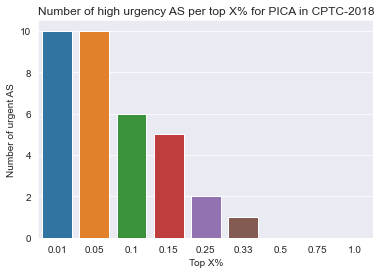

In [73]:
sns.barplot(x=percentages, y=percentage_nr_hi)
plt.title("Number of high urgency AS per top X% for PICA in CPTC-2018")
plt.ylabel("Number of urgent AS")
plt.xlabel("Top X%")
plt.savefig("./figs/percentage-high-urgency.png")
plt.show()

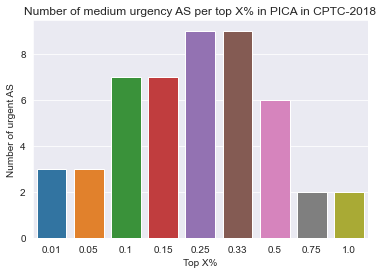

In [74]:
sns.barplot(x=percentages, y=percentage_nr_me)
plt.title("Number of medium urgency AS per top X% in PICA in CPTC-2018")
plt.ylabel("Number of urgent AS")
plt.xlabel("Top X%")
plt.savefig("./figs/percentage-med-urgency.png")
plt.show()

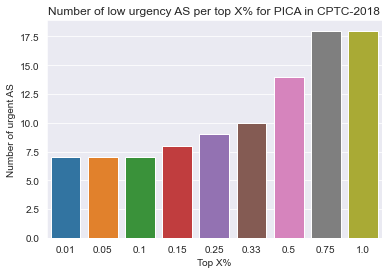

In [75]:
sns.barplot(x=percentages, y=percentage_nr_lo)
plt.title("Number of low urgency AS per top X% for PICA in CPTC-2018")
plt.ylabel("Number of urgent AS")
plt.xlabel("Top X%")
plt.savefig("./figs/percentage-low-urgency.png")
plt.show()

8 ['DATA_DELIVERY', 'DATA_MANIPULATION', 'ARBITRARY_CODE_EXE', 'DATA_EXFILTRATION', 'REMOTE_SERVICE_EXP', 'ROOT_PRIV_ESC', 'ACCT_MANIP', 'RESOURCE_HIJACKING']
3 ['VULN_DISC', 'SERVICE_DISC', 'NETWORK_DOS']
9 ['INFO_DISC', 'HOST_DISC', 'SURFING', 'TRUSTED_ORG_EXP', 'COMMAND_AND_CONTROL', 'BRUTE_FORCE_CREDS', 'USER_PRIV_ESC', 'DATA_DESTRUCTION', 'PUBLIC_APP_EXP']


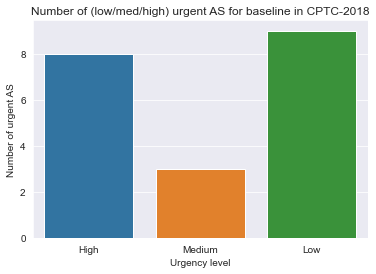

In [91]:
base_aif = get_baseline(final)
# print_sorted_dic(base_aif)

base_high = get_urgency_ais(base_aif, "HIGH")
base_med = get_urgency_ais(base_aif, "MED")
base_low = get_urgency_ais(base_aif, "LOW")

print(len(base_high), base_high)
print(len(base_med), base_med)
print(len(base_low), base_low)

sns.barplot(x=["High", "Medium", "Low"], y=[len(base_high), len(base_med), len(base_low)])
plt.title("Number of (low/med/high) urgent AS for baseline in CPTC-2018")
plt.ylabel("Number of urgent AS")
plt.xlabel("Urgency level")
plt.savefig("./figs/urgency-distribution-base.png")
plt.show()

### Qualitative analysis of attack stage types

# RQ 2
### distance to the (closest) root

In [16]:
# final = nx.nx_agraph.read_dot("./2017AGs/combined/combined-2017.dot")

In [52]:
# Distance to root node
def get_root_nodes(graph):
    roots = []
    for node in graph.nodes:
        if len(graph.out_edges(node)) == 0:
            roots.append(node)

    return roots

def distance_to_closest_root(graph, node):
    roots = get_root_nodes(graph)
    if debug: print("Roots", roots)
    length = math.inf
    for root in roots:
        try:
            length = min(nx.shortest_path_length(graph, node, root), length)
        except:
            if debug: print("No path from " + node + " to", root)
            continue

    if length == math.inf:
        raise Exception("Could not find a root.")

    return length

def print_distances(graph, urgence):
    arr = sorted(urgence.items(), key= lambda x : -x[1])
    for i,el in enumerate(arr):
        root_distance = distance_to_closest_root(graph, el[0])
        start_distance = distance_to_closest_start(graph, el[0])
        print(i+1,str(el) + " Root: " + str(root_distance) + " Start: " + str(start_distance))

In [18]:
pica = get_pica_nodes(final, 1, 1, 1)

# High PRIO >0.66
high_prio = [(k,v) for k,v in pica.items() if v > 0.5]
print(high_prio)
print(len(high_prio))
# print_sorted_dic(pica)
print_distances(final, pica)

0.19999999999999998
0.15
0.15
0.15
0.19999999999999998
0.15
0.19999999999999998
0.15
0.15
0.15
0.19999999999999998
0.15
0.15
0.15
0.15
0.19999999999999998
0.19999999999999998
0.15
0.15
0.19999999999999998
0.15
0.19999999999999998
0.15
0.19999999999999998
0.15
0.15
0.15
0.15
0.15
0.19999999999999998
0.15
0.15
0.15
0.15
0.15
0.19999999999999998
0.15
0.15
0.15
0.19999999999999998
0.19999999999999998
0.15
0.15
0.15
0.19999999999999998
0.15
1 ('DATA MANIPULATION\r\nhttp | ID: 20', 1.0)
2 ('DATA EXFILTRATION\r\nUnknown | ID: 30', 0.9466666666666667)
3 ('NETWORK DoS\r\nhttp | ID: 6', 0.9466666666666663)
4 ('ACCOUNT MANIPULATION\r\nhttp | ID: 422', 0.8533333333333332)
5 ('ROOT PRIVILEGE ESCALATION\r\nhttp | ID: 158', 0.8533333333333332)
6 ('DATA EXFILTRATION\r\nhttp | ID: 18', 0.84)
7 ('DATA DELIVERY\r\nhttp | ID: 22', 0.7866666666666667)
8 ('ROOT PRIVILEGE ESCALATION\r\nhttp | ID: 165', 0.7866666666666664)
9 ('INFO DISCOVERY\r\nhttp', 0.7466666666666665)
10 ('RESOURCE HIJACKING\r\nhttp | ID: 

NameError: name 'distance_to_closest_start' is not defined

In [296]:
baseline = get_baseline_nodes(final)
high_prio = [(k,v) for k,v in baseline.items() if v > 0.66]

print(high_prio)
print(len(high_prio))
print_distances(final, baseline)

[('DATA DELIVERY\ndistinct | ID: 420', 0.75), ('DATA DELIVERY\ndistinct | ID: 75', 0.75), ('DATA EXFILTRATION\ndistinct | ID: 419', 1.0), ('DATA DELIVERY\nhttp | ID: 252', 0.75), ('DATA DELIVERY\nhttp | ID: 21', 0.75), ('DATA EXFILTRATION\nhttp | ID: 26', 1.0), ('DATA EXFILTRATION\nhttp | ID: 234', 1.0), ('DATA DELIVERY\nremoteware-cl | ID: 413', 0.75), ('DATA EXFILTRATION\nremoteware-cl | ID: 71', 1.0), ('DATA DELIVERY\nUnknown | ID: 414', 0.75), ('DATA EXFILTRATION\nesmagent | ID: 72', 1.0), ('DATA DELIVERY\nwap-wsp | ID: 74', 0.75), ('DATA DELIVERY\nwap-wsp | ID: 416', 0.75), ('DATA EXFILTRATION\nwap-wsp | ID: 73', 1.0), ('DATA DELIVERY\nwsman | ID: 64', 0.75), ('DATA EXFILTRATION\nmicrosoft-ds | ID: 36', 1.0), ('DATA EXFILTRATION\nmicrosoft-ds | ID: 389', 1.0), ('DATA EXFILTRATION\nmicrosoft-ds | ID: 296', 1.0), ('DATA EXFILTRATION\ndistinct | ID: 76', 1.0), ('DATA EXFILTRATION\nhttp-alt | ID: 25', 1.0), ('DATA EXFILTRATION\nhttp | ID: 294', 1.0), ('DATA EXFILTRATION\nwebsm | ID: 8

In [429]:
# x = position
# y = distance to root
def graph_dist_to_root(graph, urgency):
    x = range(1,len(urgency) + 1)
    y = []

    arr = sorted(urgency.items(), key= lambda x : (-x[1], distance_to_closest_root(graph, x[0])))


    for i,el in enumerate(arr):
        y.append(distance_to_closest_root(graph, el[0]))
    plt.figure(figsize=(8, 6))
    chart = sns.scatterplot(x=x, y=y)

    chart.set_xlabel('Urgency ranking')
    chart.set_ylabel('Distance to closest root')
    chart.set(xlim=(0,None))
    return chart

def graph_dist_to_start(graph, urgency):
    x = range(1,len(urgency) + 1)
    y = []

    arr = sorted(urgency.items(), key= lambda x : (-x[1], distance_to_closest_root(graph, x[0])))

    for i,el in enumerate(arr):
        y.append(distance_to_closest_start(graph, el[0]))
    plt.figure(figsize=(8, 6))
    chart = sns.scatterplot(x=x, y=y)

    chart.set_xlabel('Urgency ranking')
    chart.set_ylabel('Distance to closest start')
    chart.set(xlim=(0,None))

    return chart


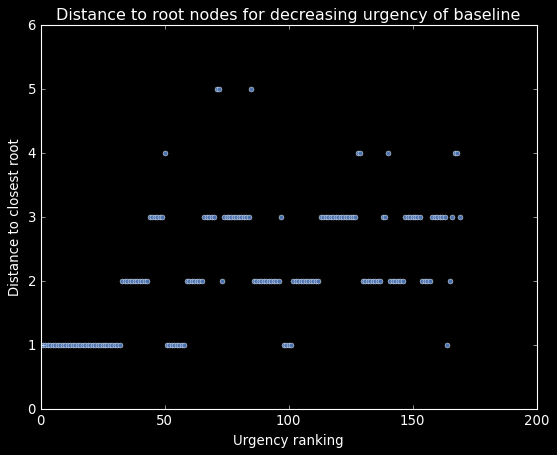

In [430]:
chart = graph_dist_to_root(final, get_baseline_nodes(final))
chart.set_title(label="Distance to root nodes for decreasing urgency of baseline")
plt.show()

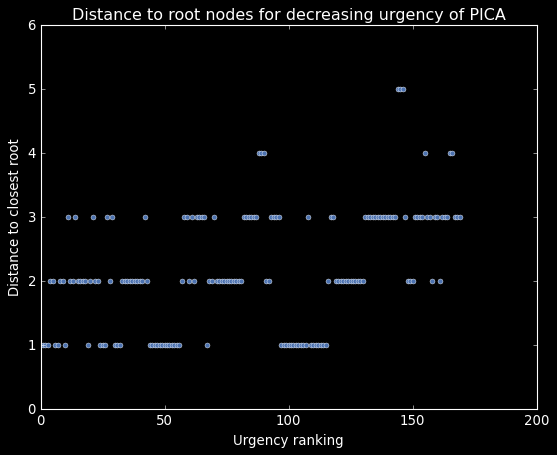

In [414]:
chart = graph_dist_to_root(final, pica)
chart.set_title(label="Distance to root nodes for decreasing urgency of PICA")
plt.show()

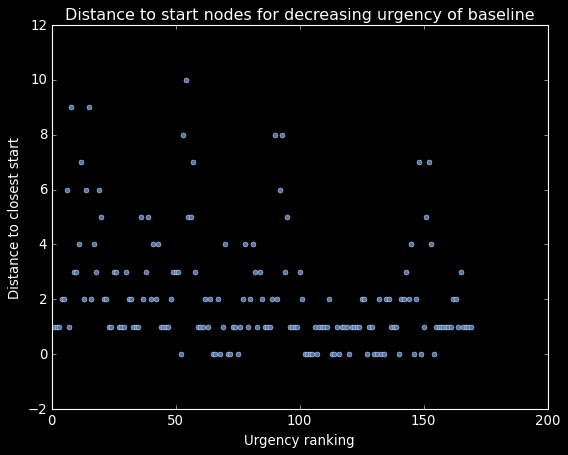

In [417]:
chart = graph_dist_to_start(final, get_baseline_nodes(final))
chart.set_title(label="Distance to start nodes for decreasing urgency of baseline")
plt.show()

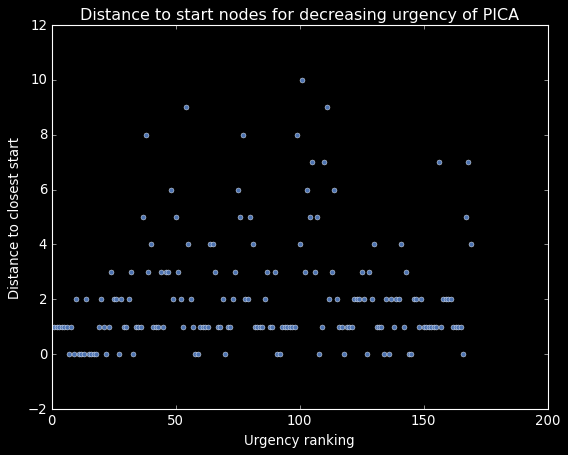

In [418]:
chart = graph_dist_to_start(final, pica)
chart.set_title(label="Distance to start nodes for decreasing urgency of PICA")
plt.show()

In [61]:
def get_urgency_scores(urgency, level="HIGH"):
    res = {}

    if level == "HIGH":
        for aif,urgence in urgency.items():
            if urgence > .5:
                res[aif] = urgence
        return res
    elif level == "MED":
        for aif,urgence in urgency.items():
            if .5 >= urgence > .25:
                res[aif] = urgence
        return res

    elif level == "LOW":
        for aif,urgence in urgency.items():
            if urgence <= .25:
                res[aif] = urgence

        return res
    else:
        raise Exception("Wrong level provided")

# Variance in urgent node distance
def get_urgency_variance(urgency, level="HIGH"):
    urgency = np.fromiter(get_urgency_scores(urgency, level).values(), dtype=float)
    if debug: print("urgencies", urgency)
    return urgency, np.var(urgency)

def get_root_distance_variance(graph, urgency, level="HIGH"):
    urgency = np.array([distance_to_closest_root(graph, node) for node,urgence in urgency.items() if urgence > 0.5])
    if debug: print("root_dists", urgency)
    return urgency, np.var(urgency)

def get_indeg_variance(graph, urgency, level="HIGH"):
    urgency = np.array([len(graph.in_edges(node)) for node,urgence in urgency.items() if urgence > 0.5])
    if debug: print("indegs", urgency)
    return urgency, np.var(urgency)

In [62]:
print("urgency variance")
print(get_urgency_variance(pica))
print(get_urgency_variance(get_baseline_nodes(final)))

print("root dist variance")
print(get_root_distance_variance(final, pica))
print(get_root_distance_variance(final, get_baseline_nodes(final)))

print("indeg variance")
print(get_indeg_variance(final, pica))
print(get_indeg_variance(final, get_baseline_nodes(final)))


urgency variance
(array([1.        , 0.78666667, 0.74666667, 0.57333333, 0.84      ,
       0.94666667, 0.85333333, 0.94666667, 0.62222222, 0.85333333,
       0.73333333, 0.78666667]), 0.01502331961591221)
(array([0.71428571, 1.        , 0.71428571, 0.57142857, 0.9047619 ,
       0.61904762, 0.57142857, 0.80952381, 1.        , 0.52380952,
       0.80952381, 0.52380952, 0.52380952, 0.80952381, 0.61904762,
       0.9047619 , 0.52380952, 0.80952381, 0.57142857, 0.80952381,
       1.        , 0.57142857, 0.61904762, 0.9047619 , 0.80952381,
       0.61904762, 0.61904762, 0.61904762, 0.61904762, 0.61904762,
       0.61904762, 1.        , 0.61904762, 1.        , 0.80952381,
       0.61904762, 0.57142857, 0.9047619 , 0.57142857, 0.61904762,
       1.        , 0.80952381, 1.        , 0.61904762, 0.9047619 ,
       0.52380952, 1.        , 0.52380952, 0.9047619 , 0.57142857,
       0.80952381, 0.52380952, 0.9047619 , 0.57142857, 1.        ,
       0.61904762, 0.80952381, 1.        , 0.71428571, 0

### distance to the (closest) starting point and

In [19]:
def get_starting_nodes(graph):
    starting_nodes = []

    for node in graph.nodes:
        if graph.nodes[node].get("fillcolor", None) == "yellow":
            starting_nodes.append(node)

    return starting_nodes

def distance_to_closest_start(graph, node):
    starting_nodes = get_starting_nodes(graph)

    length = float('inf')

    for start in starting_nodes:
        try:
            length = min(nx.shortest_path_length(graph, start, node), length)
        except:
            continue

    return length

### the number of in-going edges.

In [345]:
# For the last RQ, the first two questions will be repeated for
# varying weights of the CIA triad.
def graph_ingoing_edges(graph, urgency):
    x = range(1,len(urgency) + 1)
    y = []

    arr = sorted(urgency.items(), key= lambda x : (-x[1], distance_to_closest_root(graph, x[0])))

    for i,el in enumerate(arr):
        y.append(len(graph.in_edges(el[0])))

    chart = sns.lineplot(x=x, y=y)
    chart.set_xlabel('Urgency ranking')
    chart.set_ylabel('Number of in-going edges')
    return chart

def graph_outgoing_edges(graph, urgency):
    x = range(1,len(urgency) + 1)
    y = []

    arr = sorted(urgency.items(), key= lambda x : (-x[1], distance_to_closest_root(graph, x[0])))

    for i,el in enumerate(arr):
        y.append(len(graph.out_edges(el[0])))

    chart = sns.lineplot(x=x, y=y)

    chart.set_xlabel('Urgency ranking')
    chart.set_ylabel('Number of out-going edges')

    return chart

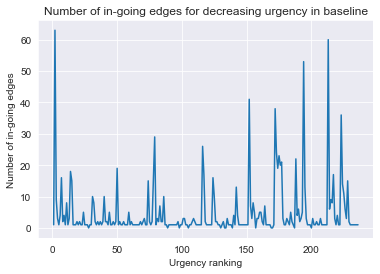

In [346]:
chart = graph_ingoing_edges(final, baseline)
chart.set_title(label="Number of in-going edges for decreasing urgency in baseline")
plt.show()

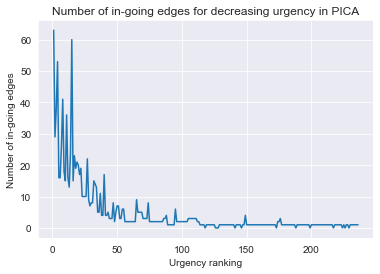

In [347]:
chart = graph_ingoing_edges(final, pica)
chart.set_title(label="Number of in-going edges for decreasing urgency in PICA")
plt.show()

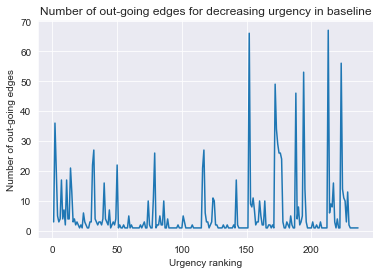

In [348]:
chart = graph_outgoing_edges(final, baseline)
chart.set_title(label="Number of out-going edges for decreasing urgency in baseline")
plt.show()

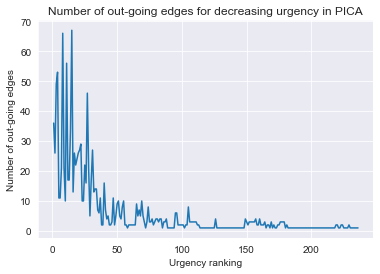

In [349]:
chart = graph_outgoing_edges(final, pica)
chart.set_title(label="Number of out-going edges for decreasing urgency in PICA")
plt.show()

In [108]:
def make_heatmap(urgency, percentage):
#     plt.style.use("dark_background")
    data_dict = urgency
    # print(data_dict)
    # Convert dictionary to DataFrame
    data = pd.DataFrame.from_dict(data_dict, orient='index', columns=['Urgency'])
    data.reset_index(inplace=True)
    data.columns = ['Attack Stage', 'Urgency']
    data.set_index("Attack Stage", inplace=True)
    data = data.sort_values("Urgency", ascending=False)
    # print(data)
    # Create the heatmap
    # heatmap_data = data.pivot(index='Attack Stage', columns='Urgency')
    # print(heatmap_data)
    plt.figure()
    sns.heatmap(data, cmap='YlOrRd', annot=True, fmt="g", vmin=0, vmax=1, cbar_kws={'label': 'Low (<=0.25) to High (>0.5) urgency'})

    # Customize the plot
#     plt.xlabel('Urgency')
    plt.ylabel('Attack Stage')
    plt.title('Attack Stage Urgency Heatmap (2018) for ' + str(percentage))
#     plt.figure(figsize=(8, 6))
    # plt.title("Percentage: " +
    # Display the heatmap
    plt.tight_layout()
    plt.savefig("./figs/heatmap" + str(percentage) + ".png")
    plt.show()


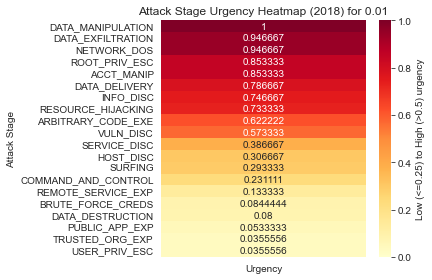

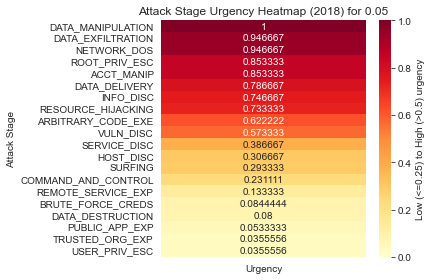

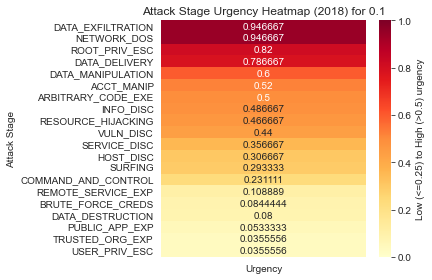

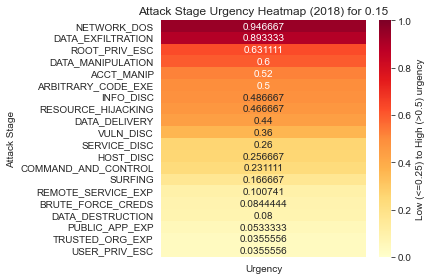

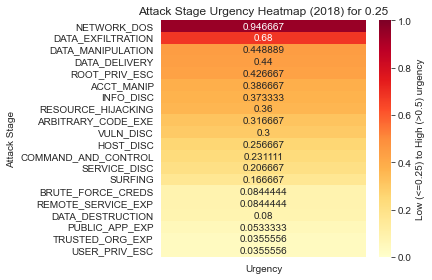

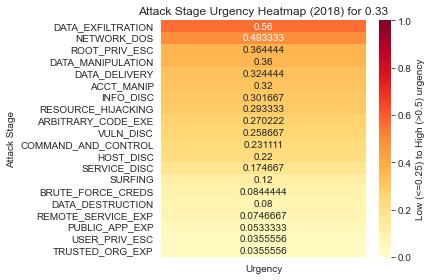

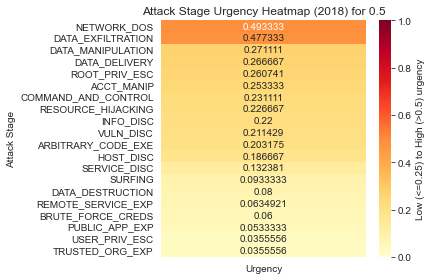

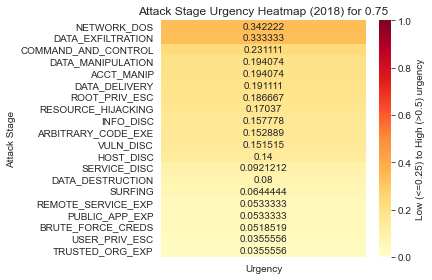

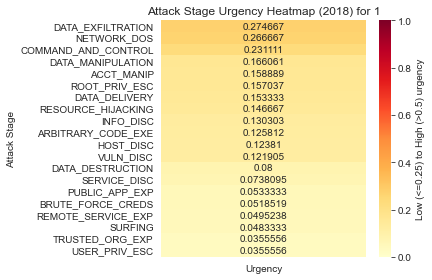

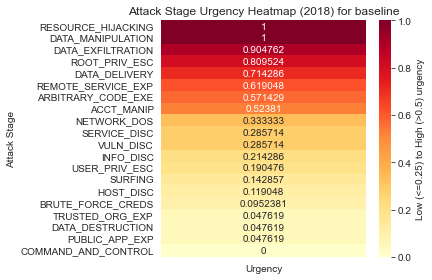

In [109]:
for percentage, urgency in zip(percentages, urgencies):
    make_heatmap(urgency, percentage)
make_heatmap(base_aif, "baseline")

In [89]:
gr_2018 = nx.nx_agraph.read_dot("./2018AGs/combined/combined-2018.dot")
gr_2017 = nx.nx_agraph.read_dot("./2017AGs/combined/combined-2017.dot")
med_complex = nx.nx_agraph.read_dot("./2018AGs/2018.txt-attack-graph-for-victim-10.0.0.24-DATADELIVERYwapwsp.dot")
high_complex = nx.nx_agraph.read_dot(r"C:\Users\senne\Documents\University\TU Delft CSE\Y3\Q4\Research Project\SAGE\2017AGs\2017.txt-attack-graph-for-victim-10.0.0.1-DATAEXFILTRATIONhttp.dot")
low_complex = nx.nx_agraph.read_dot(r"C:\Users\senne\Documents\University\TU Delft CSE\Y3\Q4\Research Project\SAGE\2017AGs\2017.txt-attack-graph-for-victim-10.0.0.27-DATADELIVERYhttp.dot")
linear = nx.nx_agraph.read_dot(r"C:\Users\senne\Documents\University\TU Delft CSE\Y3\Q4\Research Project\SAGE\2018AGs\2018.txt-attack-graph-for-victim-10.0.1.5-DATADELIVERYhttp.dot")

graphs = [gr_2017, gr_2018, high_complex, med_complex, low_complex, linear]
graph_names = ["gr_2017", "gr_2018", "high_complex", "med_complex", "low_complex", "linear"]

percentages = [0.01, 0.05,0.10, 0.15,0.25,0.33, 0.50, 0.75,1]

graphs_dict = dict()

for name, graph in zip(graph_names, graphs):
    graphs_dict[name] = dict()
    for percentage in percentages:
        # Get AS urgency for graph-percentage combination
        c_urgency = get_pica(graph, 1, 1, 1, percentage)
        graphs_dict[name][percentage] = [len(get_urgency_ais(c_urgency, "HIGH")), len(get_urgency_ais(c_urgency, "MED")), len(get_urgency_ais(c_urgency, "LOW"))]
# for k,v in graphs_dict.items():
#     print(k)
#     for perc, st in v.items():
#         print(perc)
#         print(st)
        
# print(graphs_dict)
for name, graph in zip(graph_names, graphs):
    base_aif = get_baseline(graph)
    # print_sorted_dic(base_aif)
    print(name)
    print([len(get_urgency_ais(base_aif, "HIGH")), len(get_urgency_ais(base_aif, "MED")), len(get_urgency_ais(base_aif, "LOW"))])

    
# print(len(len(base_high)))

gr_2017
[2, 5, 12]
gr_2018
[8, 3, 9]
high_complex
[1, 2, 13]
med_complex
[3, 4, 6]
low_complex
[2, 1, 6]
linear
[6, 1, 7]


In [24]:
def get_sub_graph_nodes(graph, ais):
    sub_graph = nx.MultiDiGraph()
    nodes = set()
    
    
    for node,data in graph.nodes(data=True):
#             if ais in node and "Victim" not in node:
        if ais in node:
            nodes.add(node)
            sub_graph.add_node(node)
            for k,v in data.items():
                sub_graph.nodes[node][k] = v
#                 sub_graph.nodes[node] = data
    neighbours = set()
    
#     print(nodes)
#     print(len(nodes))
    for node in nodes:
#         if not sub_graph.has_node(node):
#             sub_graph.add_node(node)
#         nodes.add(node)
        
        for start, end, key, data in graph.in_edges(node, keys=True, data=True):
            if not sub_graph.has_node(start):
                sub_graph.add_node(start)
                for k,v in graph.nodes[start].items():
                    sub_graph.nodes[start][k] = v
            if not sub_graph.has_edge(start,end,key=key):
                sub_graph.add_edge(start, end, key=key, data=data)
#             neighbours.add(start)
        for start, end, key, data in graph.out_edges(node, keys=True, data=True):
#             if "Victim" in end: continue
            if not sub_graph.has_node(end):
                sub_graph.add_node(end)
                for k,v in graph.nodes[end].items():
                        sub_graph.nodes[end][k] = v
            if not sub_graph.has_edge(start,end,key=key):
                sub_graph.add_edge(start, end, key=key, data=data)
#             neighbours.add(end)
    
    
#     nx.nx_agraph.write_dot(graph.subgraph(nodes.union(neighbours)), "./figs/subgraph2018.dot")
    return sub_graph
#     nx.draw(graph.subgraph(nodes))
#     plt.figure()
#     nx.draw(graph.subgraph(neighbours))
#     plt.figure()
#     nx.draw(graph.subgraph(nodes.union(neighbours)))
            
    # Loop over nodes
        # For each node go over in going neighbours
            # Add each neighbour + the ingoing edge
    
    # Visualise the graph with pygraphviz 

In [25]:
def save_attack_stage_subgraphs(graph):
    ases = set()
    
    for node in graph.nodes:
        if "Victim" in node:
            continue
        ases.add(get_attack_stage(node))
        
        
    for ais in ases:
        sub_graph = get_sub_graph_nodes(graph, verbose_micro[ais])
#         plt.figure()
#         nx.draw(sub_graph)
        nx.nx_agraph.write_dot(sub_graph, "./figs/2017_as/" + ais + ".dot")

In [26]:
graph = nx.nx_agraph.read_dot("./2017AGs/combined/combined-2017.dot")

In [13]:
def combine_graphs(directory):
    # Combine graphs
    graph = None
    for file in os.listdir(directory):
        # Read all dot files
        if file.endswith(".dot"):
            graph_2 = nx.nx_pydot.read_dot(directory + "/" + file)

            # If first graph from directory
            if graph is None:
                graph = graph_2
                # break
                continue

            # Join graphs
            graph = nx.compose(graph, graph_2)

    return graph

graph = combine_graphs("./2017AGs",)

In [162]:
get_sub_graph_nodes(graph, "NETWORK DoS")

In [27]:
save_attack_stage_subgraphs(graph)

In [ ]:
print("-------")
for g in [gr_2017, gr_2018]:
    print("#nodes")
    print("-------")

In [21]:
gr_2018 = nx.nx_agraph.read_dot("./2018AGs/combined/combined-2018.dot")
gr_2017 = nx.nx_agraph.read_dot("./2017AGs/combined/combined-2017.dot")

In [22]:
len(gr_2017.nodes)

331

In [23]:
len(gr_2018.nodes)

247

In [73]:
s = gr_2017

In [74]:
aif_map = dict()
ases = []
for node in s:
    if "Victim" in node:
        node = ''.join(node.splitlines(keepends=True)[1:])
#     aif_map[get_attack_stage(node)] = aif_map.get(get_attack_stage(node), 0) + 1
    ases.append(get_attack_stage(node))

# print(aif_map)
# print(sum(aif_map.values()))
# print(len(s.nodes))
df = pd.DataFrame(ases, columns=["AS"])
df = df.groupby(["AS"])["AS"].count().reset_index(name="count")
print(sum(df["count"]))
print(df.to_string())
# df = pd.DataFrame.from_dict(aif_map, columns=["AS", "Count"])

331
                     AS  count
0            ACCT_MANIP     25
1    ARBITRARY_CODE_EXE     22
2     BRUTE_FORCE_CREDS     20
3   COMMAND_AND_CONTROL     16
4         DATA_DELIVERY     52
5     DATA_EXFILTRATION     74
6     DATA_MANIPULATION      2
7       DEFENSE_EVASION      1
8             HOST_DISC      9
9             INFO_DISC     10
10          NETWORK_DOS     33
11             PRIV_ESC      2
12       PUBLIC_APP_EXP      1
13   REMOTE_SERVICE_EXP     12
14        ROOT_PRIV_ESC      5
15         SERVICE_DISC     19
16              SURFING      8
17        USER_PRIV_ESC      6
18            VULN_DISC     14


In [62]:
ases = []
for node in s:
    if "Victim" in node: continue
#     aif_map[get_attack_stage(node)] = aif_map.get(get_attack_stage(node), 0) + 1
    ases.append(len(s.in_edges(node)))

# print(aif_map)
# print(sum(aif_map.values()))
# print(len(s.nodes))
df = pd.DataFrame(ases, columns=["indeg"])
df = df.indeg.drop_duplicates()
# print(df.to_string())
print(df.to_string())
# df = pd.DataFrame.from_dict(aif_map, columns=["AS", "Count"])

0       2
1      14
2      13
3       5
4      23
5      27
6      37
9      30
10     21
12      3
14      9
15     17
16     12
18     16
19      8
20     22
21     10
26     20
28      4
29     29
31      1
33     33
34     19
43      6
48     11
86      7
88     18
130     0
155    15


In [75]:
s = gr_2018

In [76]:
aif_map = dict()
ases = []
for node in s:
    if "Victim" in node:
        node = ''.join(node.splitlines(keepends=True)[1:])
#     aif_map[get_attack_stage(node)] = aif_map.get(get_attack_stage(node), 0) + 1
    ases.append(get_attack_stage(node))

# print(aif_map)
# print(sum(aif_map.values()))
# print(len(s.nodes))
df = pd.DataFrame(ases, columns=["AS"])
# print(df.to_string())
df = df.groupby(["AS"])["AS"].count().reset_index(name="count")
print(sum(df["count"]))
print(df.to_string())
# df = pd.DataFrame.from_dict(aif_map, columns=["AS", "Count"])

247
                     AS  count
0            ACCT_MANIP     13
1    ARBITRARY_CODE_EXE     13
2     BRUTE_FORCE_CREDS      3
3   COMMAND_AND_CONTROL      1
4         DATA_DELIVERY     22
5      DATA_DESTRUCTION      2
6     DATA_EXFILTRATION     29
7     DATA_MANIPULATION     27
8             HOST_DISC      7
9             INFO_DISC     10
10          NETWORK_DOS     14
11       PUBLIC_APP_EXP      2
12   REMOTE_SERVICE_EXP     15
13   RESOURCE_HIJACKING     28
14        ROOT_PRIV_ESC     19
15         SERVICE_DISC     14
16              SURFING      8
17      TRUSTED_ORG_EXP      2
18        USER_PRIV_ESC      5
19            VULN_DISC     13


In [65]:
ases = []
for node in s:
    if "Victim" in node: continue
#     aif_map[get_attack_stage(node)] = aif_map.get(get_attack_stage(node), 0) + 1
    ases.append(len(s.in_edges(node)))

# print(aif_map)
# print(sum(aif_map.values()))
# print(len(s.nodes))
df = pd.DataFrame(ases, columns=["indeg"])
df = df.indeg.drop_duplicates()
# print(df.to_string())
print(df.to_string())
# df = pd.DataFrame.from_dict(aif_map, columns=["AS", "Count"])

0      3
1     20
2     16
3     25
4     15
6     37
7     21
9      1
10    13
14     2
16     5
23     4
27    17
33    22
44    11
45    18
48     8
73    14
79     9
94     0
